In [35]:
def find_file_with_key(directory, key):
    try:
        for entry in os.scandir(directory):
            if entry.is_file() and key in entry.name:
                return os.path.join(directory, entry.name)

    except FileNotFoundError:
        return None

def datetime64_to_seconds(timestamps):
    return (timestamps - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's') % (24 * 3600)
    return seconds.astype(int)

def closest_file(seconds, digits, sorted_files):
    closest_files = []
    previous_closest_file = None
    for i in seconds:
        diff = np.abs(np.array(digits) - i)
        idx = np.argmin(diff)
        closest_file = sorted_files[idx]
        closest_files.append(closest_file)
        previous_closest_file = closest_file
    return closest_files

def filter_files(file_list, M, D):
    pattern = f'{M}{D}'+'_([0-9]{5})SOD.dat'
    matched_files = [(int(re.match(pattern, file).group(1)), file) for file in file_list if re.match(pattern, file)]
    matched_files.sort()
    sorted_files = [file for _, file in matched_files]
    digits = [int(re.match(pattern, file).group(1)) for _, file in matched_files]
    return (sorted_files, digits)

In [2]:
import re
import numpy as np
import os
import xarray as xr 
import glob

In [91]:

f = 'Flight_20200126a'
fnum = str(f[7:-1])

Y, M, D = fnum[0:4], fnum[4:6], fnum[6:]
altitude = 10000
data_raw_path = f'/projekt_agmwend2/data_raw/EUREC4A_raw_only/06_Flights/{f}'
data_path     = f'/projekt_agmwend2/data/EUREC4A/06_Flights/{f}'

atmos_path = f'/projekt_agmwend/data/EUREC4A/03_Soundings/RS_for_libradtran/Merged/{M}{D}/'


params_path = find_file_with_key(data_path+'/BAHAMAS', '.nc')

lib_file_path = '/projekt_agmwend/data/EUREC4A/11_VELOX-Tools/libradtran/'

o3 = 375
temporal_resolution = 600

nav_inp = 1
datestring = f"{Y} {M} {D}"

In [20]:
nav_gpspos_path = find_file_with_key(data_raw_path+'/horidata/NavCommand', 'Nav_GPSPos')
params_path = glob.glob(os.path.join('/projekt_agmwend/data/EUREC4A/06_Flights',f,'BAHAMAS')+'/*.nc')[0]

xrparams = xr.open_dataset(params_path)

xrHALO = xr.Dataset(
    data_vars=dict(
        lat=(["time"], xrparams['IRS_LAT'].values),
        lon=(["time"], xrparams['IRS_LON'].values),
        alt=(["time"], xrparams['IRS_ALT'].values),
        roll=(["time"], xrparams['IRS_PHI'].values),
        pitch=(["time"], xrparams['IRS_THE'].values),
        hdg=(["time"], xrparams['IRS_HDG'].values),
        gs=(["time"], xrparams['IRS_GS'].values),

    ),
    coords=dict(

        time=xrparams['TIME'].values,
    ),
)

nav_5s_resample = xrHALO.resample(time='600S').mean()

array_sod = datetime64_to_seconds(nav_5s_resample.time.values)
array_lat = nav_5s_resample.lat.values
array_lon = nav_5s_resample.lon.values
array_alt = nav_5s_resample.alt.values

# Temporal resolution in seconds

# Create a datestring by concatenating substrings of the date variable


In [128]:

array_sorted_atmos_files, array_seconds_of_day_atmos_files = filter_files(os.listdir(atmos_path), M, D)

array_matched_atmos_files = closest_file(array_sod, array_seconds_of_day_atmos_files, array_sorted_atmos_files)


In [130]:
def start_libradtran(ts, lat, lon, alt, atmos_file, ozone, date, channel):
    lib_file_path = '/projekt_agmwend/data/EUREC4A/11_VELOX-Tools/libradtran'
    home_path = '/home/jomueller/sim_test/'
    
    wavelength_ranges = {
        0: "7700 12000",
        1: "8095 9195",
        2: "10350 11130",
        3: "10847 12000",
        4: "11500 12000"
    }

    # Define a wavelength range for the specified channel
    wavelength_range = wavelength_ranges.get(channel, "")
    if not wavelength_range:
        print(f"Error: Invalid channel {channel}")
        return
    
    # Create the input file with the specified parameters
    input_file = f'{home_path}/VELOX_{channel}_TB_{date}.inp'
    with open(input_file, 'w') as f:
        f.write('data_files_path /opt/libradtran/2.0.4/share/libRadtran/data\n')
        f.write('rte_solver disort\n')
        f.write('mol_abs_param reptran medium\n')
        f.write('atmosphere_file /projekt_agmwend/data/EUREC4A/11_VELOX-Tools/add_data/afglt_evi.dat\n')
        f.write(f'radiosonde {atmos_file} H2O RH\n')
        f.write(f'time {ts}\n')
        f.write(f'latitude {"S" if lat < 0 else "N"} {abs(lat)}\n')
        f.write(f'longitude {"W" if lon < 0 else "E"} {abs(lon)}\n')
        f.write(f'zout {alt}\n')
        f.write('phi 0.0\n')
        f.write('umu 1.0\n')
        f.write(f'wavelength {wavelength_range}\n')
        f.write('source thermal\n')
        f.write('output_process per_nm\n')
        f.write('output_process integrate\n')
        f.write('output_quantity brightness\n')
        f.write('output_user lambda sza uu\n')
        f.write('albedo_library IGBP\n')
        f.write('brdf_rpv_type 17\n')
        f.write('sur_temperature 300\n')
        f.write(f'mol_modify O3 {ozone}  DU\n')
        f.write('aerosol_default\n')
    
    # Run the UVSPEC program
    cmd = f'/opt/libradtran/2.0.4/bin/uvspec < {input_file} > {home_path}/VELOX'
    os.system(cmd)
    return

In [131]:
ts = nav_5s_resample.time.dt.strftime('%Y %m %d %H %M %S').values
ts[0]

'2020 02 05 09 10 00'

In [10]:
atmos_path+array_matched_atmos_files[17]

'/projekt_agmwend/data/EUREC4A/03_Soundings/RS_for_libradtran/Merged/0126/0126_53321SOD.dat'

In [11]:
atmos_file = atmos_path+ array_matched_atmos_files[17]


In [12]:
t = ts[17]
start_libradtran(t, array_lat[17], array_lon[17], array_alt[17]/1e5, atmos_file, 375, fnum, 2)

 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
 ... setting number_of_streams to 16 for radiance calculation!

*** WARNING: The atmosphere defined in /projekt_agmwend/data/EUREC4A/11_VELOX-Tools/add_data/afglt_evi.dat
*** is not in hydrostatic equilibrium (assuming the graviational acceleration of Earth).
*** This might not be what you want and could affect your interpretation of the results
*** because several relationships which are based on the implicit assumption of
*** hydrostatic equilibrium are not true in this case. E.g. heating rates in uvspec are
*** calculated from dE_net / dz and not from dE_net / dp which would give different
*** results. Also, layer optical thicknesses are calculated from pressure and layer
*** thickness. The radiative t

In [137]:
channel_string = 
        "Channel 0" : "7700 12000",
        1: "8095 9195",
        2: "10350 11130",
        3: "10847 12000",
        4: "11500 12000"
    }

In [158]:
ds_t.attrs['wavelength_range'] = '\n'.join([f'Channel {i} : {wavelength_ranges.get(i, "")}[nm] \n' for i in range(5)])

In [168]:
ds_sel.sel(interpolated_time=ds_sel.interpolated_time[0]).plot()

KeyError: 'no index found for coordinate interpolated_time'

In [178]:
ds_sel.interpolated_time.min()

<xarray.DataArray 'interpolated_time' ()>
array('NaT', dtype='datetime64[ns]')

In [183]:
ds_sod = datetime64_to_seconds(ds_sel.interpolated_time.values)


new_time = np.linspace(start=ds_sod.min().item(), 
                       stop=ds_sod.max().item(), 
                       num=ds_sod.size)

# Interpolate the data onto the new interpolated_time coordinates
interp_ds = ds_sel.interp(interpolated_time=new_time, method='linear')

/tmp/user/1431/ipykernel_3756457/518200552.py:11: RuntimeWarning: invalid value encountered in remainder
  return (timestamps - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's') % (24 * 3600)


ValueError: Dimensions {'interpolated_time'} do not exist. Expected one or more of Frozen({'alt': 1001, 'sonde_id': 70, 'nv': 2})

In [180]:
datetime64_to_seconds(ds_sel.interpolated_time.values)

/tmp/user/1431/ipykernel_3756457/518200552.py:11: RuntimeWarning: invalid value encountered in remainder
  return (timestamps - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's') % (24 * 3600)


array([[   nan, 45598., 45598., ..., 44849., 44848., 44848.],
       [   nan, 45850., 45850., ..., 45125., 45124., 45124.],
       [   nan, 46106., 46105., ..., 45338., 45337., 45336.],
       ...,
       [   nan, 75058., 75057., ..., 74290., 74290., 74289.],
       [   nan, 75290., 75289., ..., 74530., 74530., 74530.],
       [   nan, 75532., 75531., ..., 74760., 74760., 74760.]])

In [161]:
ds_53321

array([[  85.764641 ,  192.33356  ,   23.566469 ],
       [  93.729126 ,  191.96238  ,   32.091274 ],
       [ 102.44702  ,  193.49174  ,   33.146862 ],
       [ 111.90512  ,  193.5639   ,   57.247787 ],
       [ 122.12927  ,  196.90856  ,   54.469898 ],
       [ 133.07314  ,  201.355    ,   54.404087 ],
       [ 144.72372  ,  205.54511  ,   34.276276 ],
       [ 157.13448  ,  208.84808  ,   59.463524 ],
       [ 170.42978  ,  212.21452  ,   55.94685  ],
       [ 184.61143  ,  215.86047  ,   34.808231 ],
       [ 199.65919  ,  220.57639  ,   21.357944 ],
       [ 215.54102  ,  225.15775  ,   16.274387 ],
       [ 232.34906  ,  229.74125  ,   15.84406  ],
       [ 250.1041   ,  234.12772  ,   11.523406 ],
       [ 268.84811  ,  237.98     ,   10.826577 ],
       [ 288.74426  ,  241.65923  ,   12.0527   ],
       [ 299.08151  ,  243.80449  ,    6.2854056],
       [ 309.71838  ,  244.37959  ,    8.7387714],
       [ 320.70108  ,  246.27351  ,    4.2752299],
       [ 331.99402  ,  247.276 

In [ ]:
os.listdir()
home_path = '/home/jomueller/sim_test/'
input_file= home_path+'VELOX_2_TB_20200126.inp'
output_file= home_path+'VELOX_2_TB_20200126.out'

In [89]:
f = 'Flight_20200126a'
fnum = str(f[7:-1])
#Y, M, D = int(fnum[0:4]), int(fnum[4:6]), int(fnum[6:])
f_format = f'HALO-{fnum[4:6]}{fnum[6:]}'



xrds = xr.open_dataset('/home/jomueller/EUREC4A_JOANNE_Dropsonde-RD41_Level_3_v2.0.0.nc').load()

select_flight = np.array([f_format in word.item() for word in xrds['sonde_id']])
ds_sel = xrds.sel(sonde_id = select_flight)
#ds_sel['ta'] = ds_sel['ta'] - 273.15

In [194]:
ds_sod[]

(70, 1001)

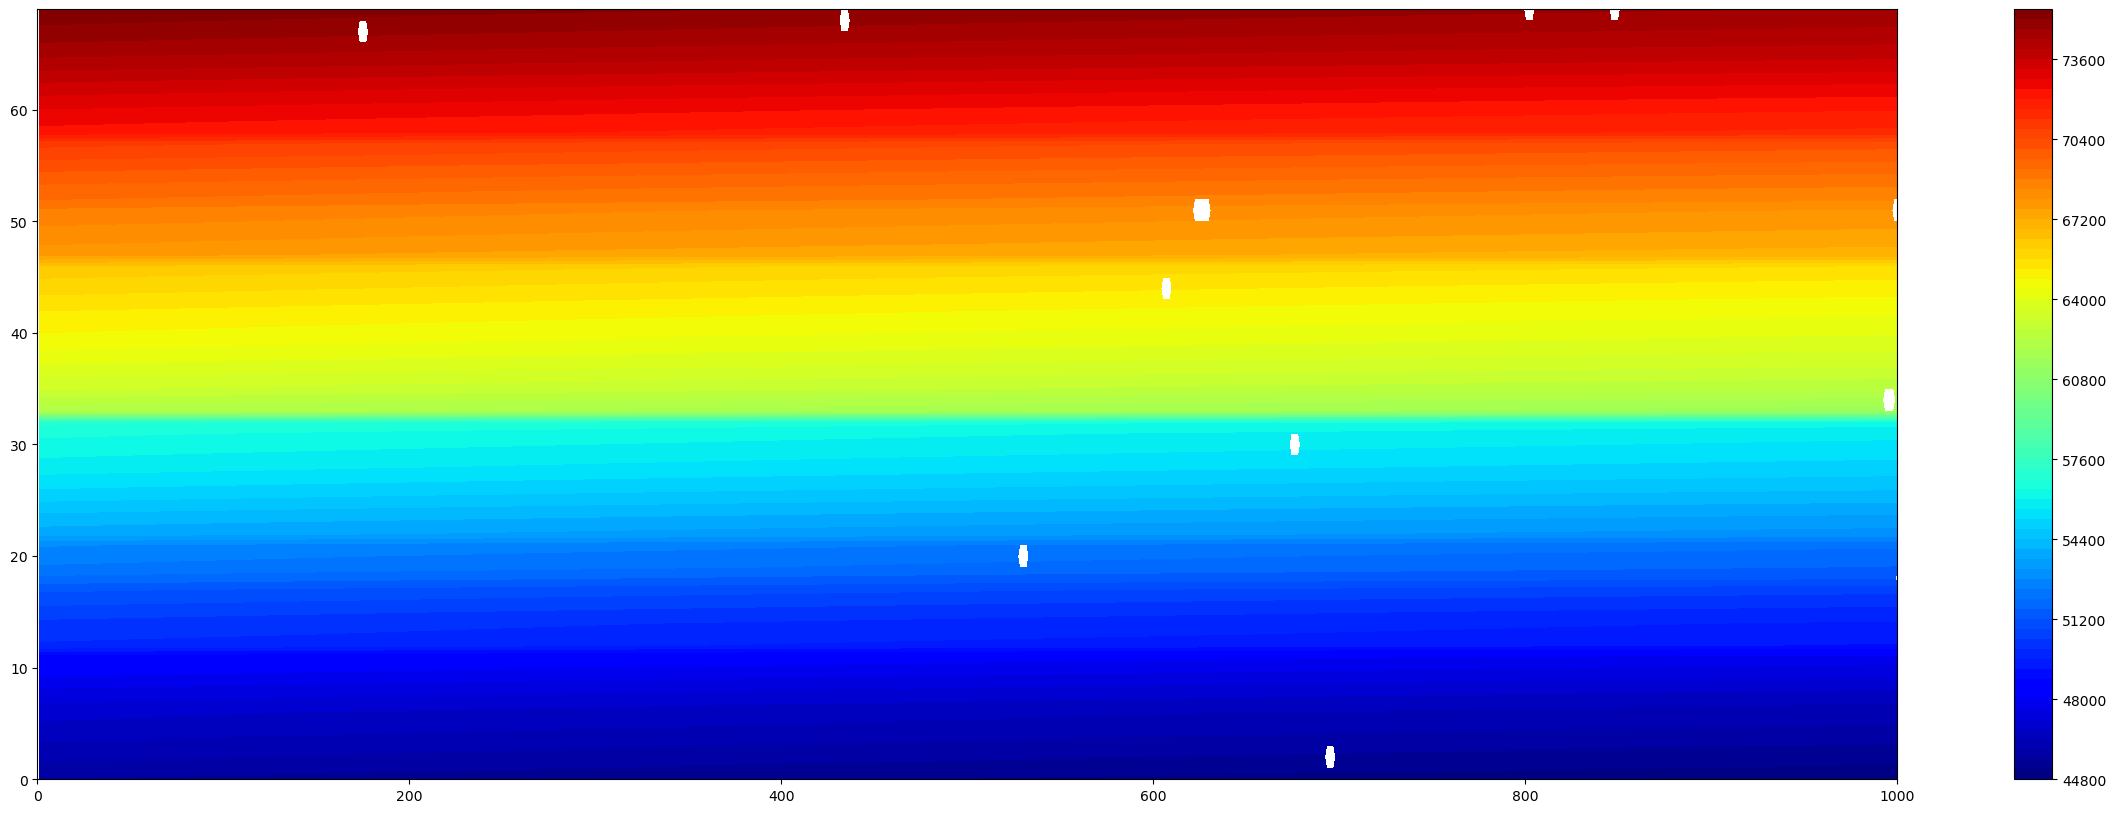

In [216]:
plt.figure(figsize=(30,10))
plt.contourf(ds_sod, levels=100, cmap='jet')
plt.colorbar()

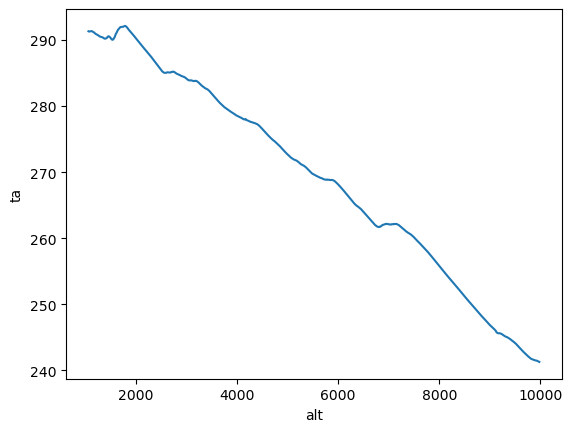

In [299]:
ds_t.where(mask).mean(dim='time').ta.plot()


In [291]:
mask.shape

(70, 1001)

In [287]:
mask[:, :]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [286]:
ds_t.p.values[mask]

array([898.85236, 897.8089 , 896.7626 , ..., 288.5731 ,       nan,
             nan], dtype=float32)

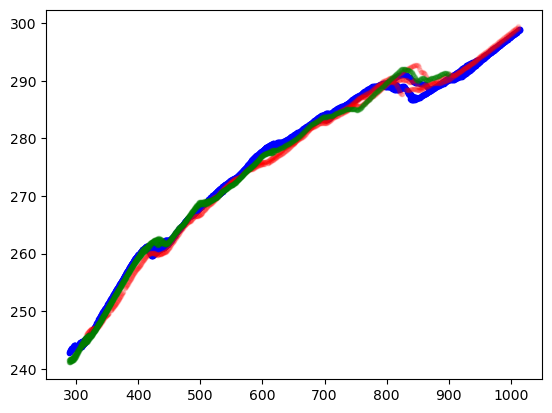

In [285]:

mask = np.isclose(ds_t.sod,  50010, atol=300)
plt.plot(ds_t.p.values[mask], ds_t.ta.values[mask], 'b.')

mask = np.isclose(ds_t.sod,  75100, atol=300)
plt.plot(ds_t.p.values[mask], ds_t.ta.values[mask], 'r.', alpha=0.1)

mask = np.isclose(ds_t.sod,  45200, atol=300)
plt.plot(ds_t.p.values[mask], ds_t.ta.values[mask], 'g.', alpha=0.2)

In [235]:
ds_t.sod[30, :]

<xarray.DataArray 'sod' (alt: 1001)>
array([   nan, 56273., 56272., ..., 55506., 55506., 55505.])
Coordinates:
    time     datetime64[ns] 2020-01-26T15:24:46
  * alt      (alt) int16 0 10 20 30 40 50 60 ... 9950 9960 9970 9980 9990 10000

/tmp/user/1431/ipykernel_3756457/518200552.py:11: RuntimeWarning: invalid value encountered in remainder
  return (timestamps - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's') % (24 * 3600)


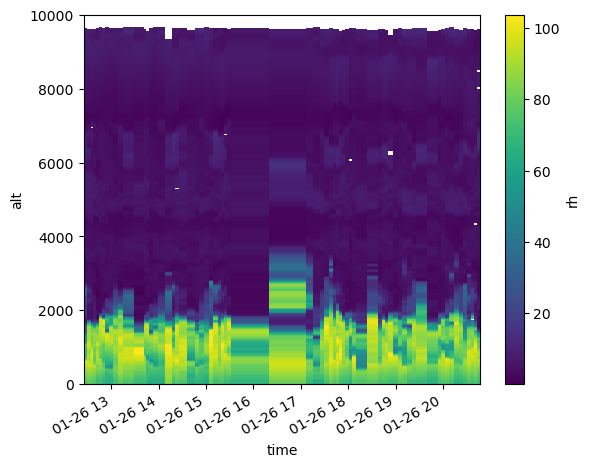

In [225]:
ds_sod = datetime64_to_seconds(ds_sel.interpolated_time.values)


ds_t = xr.Dataset(
    data_vars=dict(
        ta = (['time', 'alt'], ds_sel.ta.values),
        #wspd = (['time', 'alt'], ds_sel.wspd.values),
        #wdir = (['time', 'alt'], ds_sel.wdir.values),
        p = (['time', 'alt'], ds_sel.p.values/100),
        rh = (['time', 'alt'], ds_sel.rh.values*100),
        sod=(['time', 'alt'], ds_sod),

    ),
    coords=dict(
        time=ds_sel.launch_time.values,
        alt=ds_sel.alt.values,
        #interp_time=ds_sel.interpolated_time.values,
    )
)

#ds_t.ta.plot(x='time')
ds_t.rh.plot(x='time')



In [134]:
array_alt / 1e3

array([ 1.5447196,  6.1482735, 10.006182 , 10.257492 , 10.2496195,
       10.253192 , 10.267242 , 10.275156 , 10.270611 , 10.259634 ,
       10.25566  , 10.263931 , 10.278156 , 10.280785 , 10.273123 ,
       10.264064 , 10.265383 , 10.2761545, 10.2873   , 10.285118 ,
       10.275636 , 10.27036  , 10.266877 , 10.25627  , 10.24227  ,
       10.237735 , 10.251563 , 10.269166 , 10.278515 , 10.276065 ,
       10.269709 , 10.270557 , 10.275553 , 10.284109 , 10.292636 ,
       10.29077  , 10.280593 , 10.271104 , 10.275575 , 10.287248 ,
       10.291805 , 10.285875 , 10.271732 , 10.26795  , 10.274794 ,
       10.284721 , 10.283886 , 10.275087 , 10.26337  , 10.263362 ,
       10.274305 , 10.281633 ,  7.5037827,  4.7776694,  1.1014168,
        0.1213216], dtype=float32)

In [74]:
dropsonde_sod = datetime64_to_seconds(ds_t.time.values)

In [109]:
ds_t.ta.isel(time=0)

<xarray.DataArray 'ta' (alt: 1001)>
array([     nan,      nan, 298.9599, ..., 242.0693,      nan,      nan],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2020-01-26T12:27:08
  * alt      (alt) int16 0 10 20 30 40 50 60 ... 9950 9960 9970 9980 9990 10000

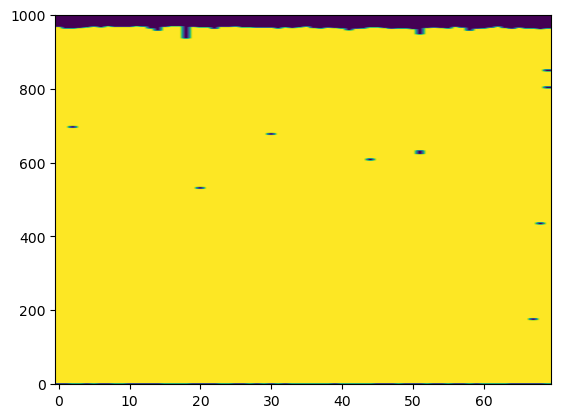

In [107]:
mask = ~np.isnan(ds_t.ta.values) & ~np.isnan(ds_t.rh.values) & ~np.isnan(ds_t.p.values)

plt.imshow(mask.T, aspect='auto', origin='lower')

In [104]:
mask = ~np.any(np.isnan(ds_t.ta), axis=0)

<xarray.DataArray (alt: 1001)>
array([False, False,  True, ..., False, False, False])
Coordinates:
    time     datetime64[ns] 2020-01-26T13:38:57
  * alt      (alt) int16 0 10 20 30 40 50 60 ... 9950 9960 9970 9980 9990 10000

In [95]:
ds_t.p.interpolate_na(dim=['alt', 'time'], method='linear')

KeyError: ['alt', 'time']

In [301]:
ds_t.sod

<xarray.DataArray 'sod' (time: 70, alt: 1001)>
array([[   nan, 45598., 45598., ..., 44849., 44848., 44848.],
       [   nan, 45850., 45850., ..., 45125., 45124., 45124.],
       [   nan, 46106., 46105., ..., 45338., 45337., 45336.],
       ...,
       [   nan, 75058., 75057., ..., 74290., 74290., 74289.],
       [   nan, 75290., 75289., ..., 74530., 74530., 74530.],
       [   nan, 75532., 75531., ..., 74760., 74760., 74760.]])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-26T12:27:08 ... 2020-01-26T20:45:42
  * alt      (alt) int16 0 10 20 30 40 50 60 ... 9950 9960 9970 9980 9990 10000

In [311]:
time_array

array([44848.        , 45157.93939394, 45467.87878788, 45777.81818182,
       46087.75757576, 46397.6969697 , 46707.63636364, 47017.57575758,
       47327.51515152, 47637.45454545, 47947.39393939, 48257.33333333,
       48567.27272727, 48877.21212121, 49187.15151515, 49497.09090909,
       49807.03030303, 50116.96969697, 50426.90909091, 50736.84848485,
       51046.78787879, 51356.72727273, 51666.66666667, 51976.60606061,
       52286.54545455, 52596.48484848, 52906.42424242, 53216.36363636,
       53526.3030303 , 53836.24242424, 54146.18181818, 54456.12121212,
       54766.06060606, 55076.        , 55385.93939394, 55695.87878788,
       56005.81818182, 56315.75757576, 56625.6969697 , 56935.63636364,
       57245.57575758, 57555.51515152, 57865.45454545, 58175.39393939,
       58485.33333333, 58795.27272727, 59105.21212121, 59415.15151515,
       59725.09090909, 60035.03030303, 60344.96969697, 60654.90909091,
       60964.84848485, 61274.78787879, 61584.72727273, 61894.66666667,
      

In [405]:
resolution = 600

time_array = np.arange(start=ds_t.sod.min().item(), stop=ds_t.sod.max().item(), step=300)
time_array.shape

(103,)

In [400]:
ds_t

<xarray.Dataset>
Dimensions:  (time: 70, alt: 1001)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-26T12:27:08 ... 2020-01-26T20:45:42
  * alt      (alt) int16 0 10 20 30 40 50 60 ... 9950 9960 9970 9980 9990 10000
Data variables:
    ta       (time, alt) float32 nan nan 299.0 298.9 ... 241.6 241.6 nan nan
    p        (time, alt) float32 nan nan 1.013e+03 1.012e+03 ... 287.6 nan nan
    rh       (time, alt) float32 nan nan 73.45 73.79 74.11 ... nan nan nan nan
    sod      (time, alt) float64 nan 4.56e+04 4.56e+04 ... 7.476e+04 7.476e+04

In [406]:
for i in range(103):
    mask = np.isclose(ds_t.sod,  time_array[i], atol=600)
    ds_matched = ds_t.where(mask).mean(dim='time')
    data = ds_matched
    mask = ~np.isnan(data.ta.values) & ~np.isnan(data.rh.values) & ~np.isnan(data.p.values)
    valid_data = data.isel(alt=mask)
    pandas_data = valid_data.to_pandas()
    pandas_data = pandas_data.iloc[::-1]
    pandas_data.to_csv(f'~/sim_test/atmos_dir/{M}{D}_{time_array[i]:.0f}SOD.dat', sep='\t', columns=['p', 'ta', 'rh'], index=False, header=False, float_format='%.6f')

In [310]:
#[ds_t.isel(time=i)[~np.isnan(ds_t.isel(time=i).ta) & ~np.isnan(ds_t.isel(time=i).rh) & ~np.isnan(ds_t.isel(time=i).p)].to_pandas().to_csv(f'~/sim_test/atmos_dir/{M}{D}_{dropsonde_sod[i]:.0f}SOD.dat', sep='\t', columns=['p', 'ta', 'rh'], index=False, header=False) for i in range(len(ds_t.time))]

In [38]:
ds_53321 = np.loadtxt(atmos_file)

In [42]:
import matplotlib.pyplot as plt

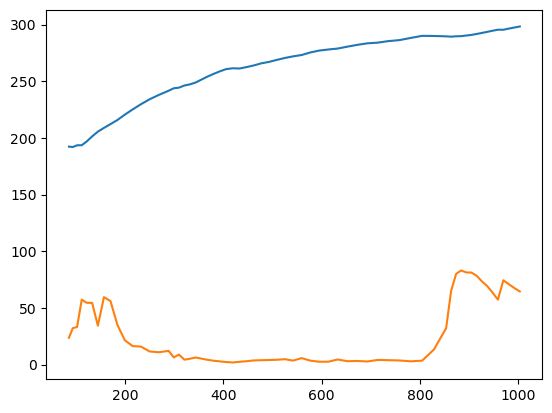

In [49]:
plt.plot(ds_53321[:,0], ds_53321[:,1])
plt.plot(ds_53321[:,0], ds_53321[:,2])

In [329]:
file

NameError: name 'file' is not defined

In [336]:
array_flight_code = [file for file in os.listdir('/projekt_agmwend/data/HALO-AC3/02_Flights') if 'HALO_RF' in file]
flight_code = array_flight_code[14]

In [343]:
ds_path = f'/projekt_agmwend/data/HALO-AC3/02_Flights/{flight_code}/dropsondes/Level_1/'

len(os.listdir(ds_path))

20

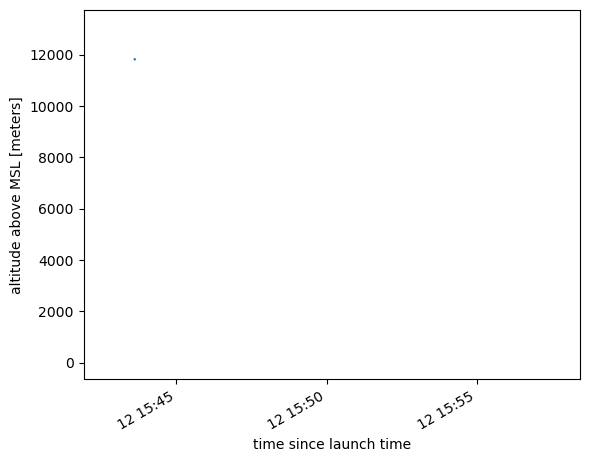

In [374]:
t.alt.plot()

In [393]:
t = xr.open_dataset(ds_path+os.listdir(ds_path)[3])
t

<xarray.Dataset>
Dimensions:         (time: 3639, obs: 1)
Coordinates:
  * time            (time) datetime64[ns] 2022-03-12T15:57:40.979980468 ... 2...
    lat             (time) float32 ...
    lon             (time) float32 ...
    gpsalt          (time) float32 ...
Dimensions without coordinates: obs
Data variables: (12/27)
    trajectory      |S1 ...
    launch_time     datetime64[ns] ...
    pres            (time) float32 ...
    tdry            (time) float32 ...
    dp              (time) float32 ...
    rh              (time) float32 ...
    ...              ...
    reference_rh    (obs) float32 ...
    reference_wspd  (obs) float32 ...
    reference_wdir  (obs) float32 ...
    reference_lat   (obs) float32 ...
    reference_lon   (obs) float32 ...
    reference_alt   (obs) float32 ...
Attributes: (12/92)
    Conventions:            CF-1.6
    RepoRevision:           V3.4.6
    RepoLastChangedDate:    Fri Apr 30 16:17:27 2021 -0600
    RepoId:                 163b1128fa837a96c93dfe8a59c915ff3185b748
    RepoBranch:             master
    featureType:            trajectory
    ...                     ...
    WindQCDev:              999
    WindQCWL:               30
    WindSats:               6
    WindSmoothWL:           10
    WindVVPresWL:           5
    WindVVdelta:            2.5

In [394]:
tm_alt = t.alt[~np.isnan(t.pres.values)]
tm_pres = t.pres[~np.isnan(t.pres.values)]
tm_tdry = t.tdry[~np.isnan(t.pres.values)]
tm_rh = t.rh[~np.isnan(t.pres.values)]


In [397]:
tm_alt

<xarray.DataArray 'alt' (time: 1700)>
array([0.000000e+00, 7.991719e+00, 1.333282e+01, ..., 1.307728e+04,
       1.308518e+04, 1.309131e+04], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-03-12T15:57:40.979980468 ... 2022-03-...
    lat      (time) float32 nan nan 71.32 71.32 ... 71.19 71.19 71.19 71.19
    lon      (time) float32 nan nan 4.105 4.105 ... 4.002 4.002 4.002 4.002
    gpsalt   (time) float32 nan nan -2.56 4.08 ... 1.307e+04 1.307e+04 1.309e+04
Attributes:
    long_name:  altitude above MSL
    units:      meters
    positive:   up

In [396]:
tm_pres.sel(alt=tm_alt[0].values)

KeyError: 'alt is not a valid dimension or coordinate'

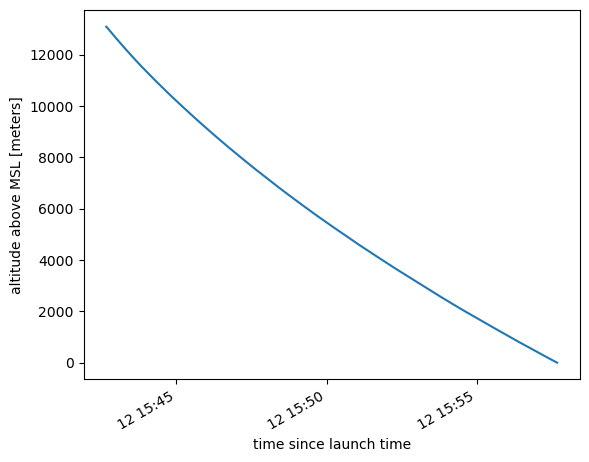

In [389]:
t.alt[~np.isnan(t.pres.values)].plot()

In [382]:
np.count_nonzero(np.isnan(t.pres.values))

1939

In [378]:
np.count_nonzero(np.isnan(t.pres))

1939

In [339]:
ds_concat = xr.concat([xr.open_dataset(os.path.join(ds_path, file)) for file in os.listdir(ds_path)], dim='sonde_id')

In [348]:
ds_concat

<xarray.Dataset>
Dimensions:         (time: 65177, sonde_id: 20, obs: 1)
Coordinates:
  * time            (time) datetime64[ns] 2022-03-12T09:27:01.190000057 ... 2...
    lat             (sonde_id, time) float32 nan nan nan nan ... nan nan nan nan
    lon             (sonde_id, time) float32 nan nan nan nan ... nan nan nan nan
    gpsalt          (sonde_id, time) float32 nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: sonde_id, obs
Data variables: (12/27)
    trajectory      (sonde_id) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    launch_time     (sonde_id) datetime64[ns] 2022-03-12T11:31:42 ... 2022-03...
    pres            (sonde_id, time) float32 nan nan nan nan ... nan nan nan nan
    tdry            (sonde_id, time) float32 nan nan nan nan ... nan nan nan nan
    dp              (sonde_id, time) float32 nan nan nan nan ... nan nan nan nan
    rh              (sonde_id, time) float32 nan nan nan nan ... nan nan nan nan
    ...              ...
    reference_rh    (sonde_id, obs) float32 nan nan nan nan ... nan nan nan nan
    reference_wspd  (sonde_id, obs) float32 nan nan nan nan ... nan nan nan nan
    reference_wdir  (sonde_id, obs) float32 nan nan nan nan ... nan nan nan nan
    reference_lat   (sonde_id, obs) float32 77.56 77.99 82.04 ... 73.99 72.54
    reference_lon   (sonde_id, obs) float32 7.121 4.007 15.25 ... 3.997 0.7649
    reference_alt   (sonde_id, obs) float32 1.231e+04 1.285e+04 ... 1.177e+04
Attributes: (12/92)
    Conventions:            CF-1.6
    RepoRevision:           V3.4.6
    RepoLastChangedDate:    Fri Apr 30 16:17:27 2021 -0600
    RepoId:                 163b1128fa837a96c93dfe8a59c915ff3185b748
    RepoBranch:             master
    featureType:            trajectory
    ...                     ...
    WindQCDev:              999
    WindQCWL:               30
    WindSats:               6
    WindSmoothWL:           10
    WindVVPresWL:           5
    WindVVdelta:            2.5

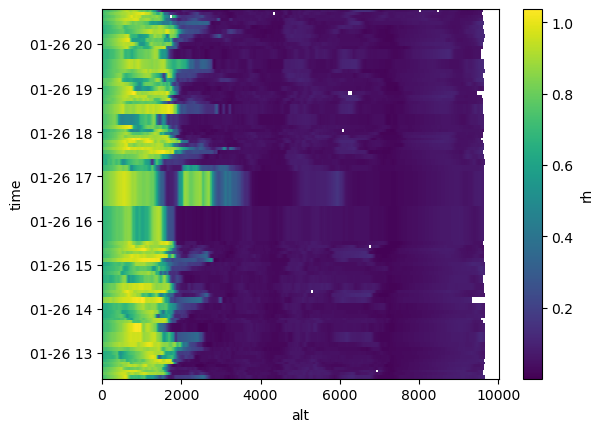

In [55]:
ds_t.rh.plot()

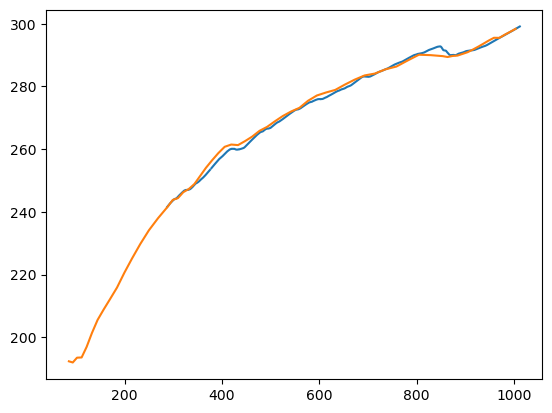

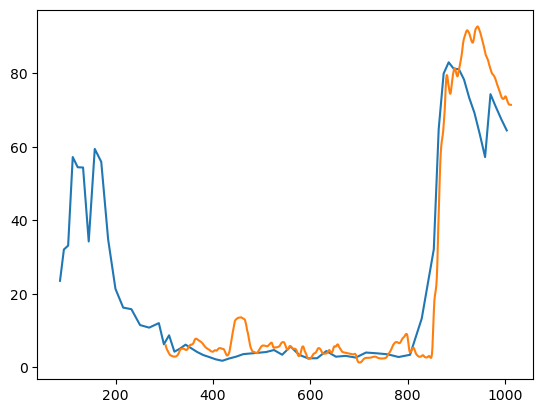

In [57]:
match = ds_t.sel(time = nav_5s_resample.time[17], method='nearest')

plt.plot(match.p / 100, match.ta)
import matplotlib.pyplot as plt

plt.plot(ds_53321[:,0], ds_53321[:,1])

plt.figure()

plt.plot(ds_53321[:,0], ds_53321[:,2])
plt.plot(match.p / 100, match.rh * 100)

In [ ]:
params_path = find_file_with_key(data_path+'/BAHAMAS', '.nc')


In [ ]:
os.listdir(data_path+'/BAHAMAS')

FileNotFoundError: [Errno 2] No such file or directory: '/projekt_agmwend2/data/EUREC4A/06_Flights/Flight_20200126a/BAHAMAS'

'2020 01 26 12 00 00'

In [ ]:
with open(output_file, "r") as f:
    lines = f.readlines()
    print(lines[-1].split()[-1])

2.994366760e+02


In [ ]:
os.listdir()

['verbose.txt',
 'libradttran_test.py',
 'VELOX_20200126_TB.nc',
 'VELOX_0_TB_20200126.inp',
 'randomseed',
 'VELOX_1_TB_20200126.out',
 'libradtran_simple.pro',
 'VELOX_0_TB_20200126.out',
 'VELOX_3_TB_20200126.inp',
 'VELOX_1_TB_20200126.inp',
 'VELOX_3_TB_20200126.out',
 'VELOX',
 'libradtran_test.ipynb',
 'VELOX_2_TB_20200126.out',
 'VELOX_2_TB_20200126.inp']

In [ ]:
import xarray as xr

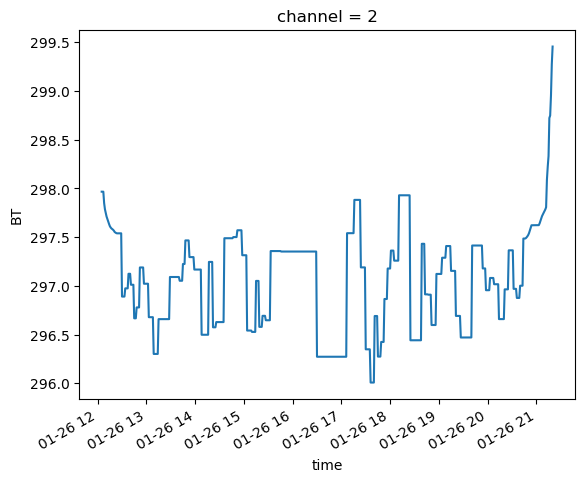

In [18]:
a.BT.sel(channel=2).plot()

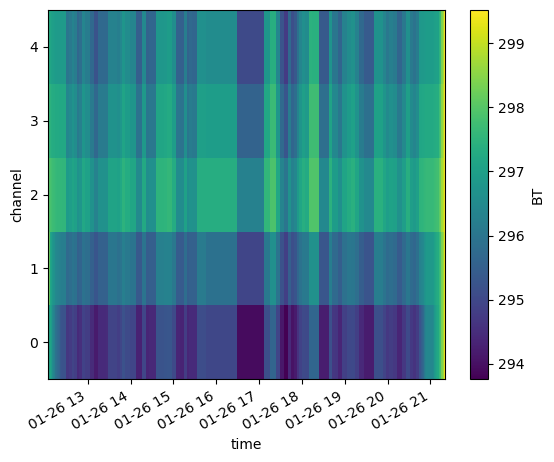

In [17]:
a = xr.open_dataset('/home/jomueller/sim_test/VELOX_20200126_60S_TB.nc')
a.BT.plot(x='time')

In [ ]:
for i, second_of_day in enumerate(array_sod):
    sod = array_sod[i]
    lat = array_lat[i]
    lon = array_lon[i]
    alt = array_alt[i]
    atmos_file = atmos_path+ array_matched_atmos_files[i]
    ozone = 375
    date = fnum
    channel = 1
    print(f'Timestep: {nav_5s_resample.time[i]}')

    start_libradtran(sod, lat, lon, alt, atmos_file, ozone, date, channel)
    


Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T12:00:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T12:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T12:10:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T12:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T12:20:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T12:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T12:30:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T12:40:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T12:40:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T12:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T12:50:00
Timestep: <xarray.Data

 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
***************************************************************************************
Error: No wavelength range selected. Please use options wavelength or wavelength_index.
***************************************************************************************
Error: No wavelength range selected.
Error -1 returned by function set_transmittance_wl_grid_reptran in (line 291, function 'setup_wlgrid', file 'ancillary.c')
Error -1 setting up transmittance wavelength grid in uvspec (uvspec.c)
Error -1 during execution of uvspec
 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profi

Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T13:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T13:20:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T13:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T13:30:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T13:40:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T13:40:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T13:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T13:50:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T14:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T14:00:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T14:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T14:10:00
Timestep: <xarray.Data

 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
***************************************************************************************
Error: No wavelength range selected. Please use options wavelength or wavelength_index.
***************************************************************************************
Error: No wavelength range selected.
Error -1 returned by function set_transmittance_wl_grid_reptran in (line 291, function 'setup_wlgrid', file 'ancillary.c')
Error -1 setting up transmittance wavelength grid in uvspec (uvspec.c)
Error -1 during execution of uvspec
 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profi

Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T14:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T14:50:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T15:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T15:00:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T15:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T15:10:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T15:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T15:20:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T15:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T15:30:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T15:40:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T15:40:00
Timestep: <xarray.Data

 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
***************************************************************************************
Error: No wavelength range selected. Please use options wavelength or wavelength_index.
***************************************************************************************
Error: No wavelength range selected.
Error -1 returned by function set_transmittance_wl_grid_reptran in (line 291, function 'setup_wlgrid', file 'ancillary.c')
Error -1 setting up transmittance wavelength grid in uvspec (uvspec.c)
Error -1 during execution of uvspec
 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profi

Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T16:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T16:30:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T16:40:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T16:40:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T16:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T16:50:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T17:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T17:00:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T17:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T17:10:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T17:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T17:20:00
Timestep: <xarray.Data

 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
***************************************************************************************
Error: No wavelength range selected. Please use options wavelength or wavelength_index.
***************************************************************************************
Error: No wavelength range selected.
Error -1 returned by function set_transmittance_wl_grid_reptran in (line 291, function 'setup_wlgrid', file 'ancillary.c')
Error -1 setting up transmittance wavelength grid in uvspec (uvspec.c)
Error -1 during execution of uvspec
 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profi

Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T18:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T18:10:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T18:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T18:20:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T18:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T18:30:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T18:40:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T18:40:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T18:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T18:50:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T19:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T19:00:00
Timestep: <xarray.Data

 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
***************************************************************************************
Error: No wavelength range selected. Please use options wavelength or wavelength_index.
***************************************************************************************
Error: No wavelength range selected.
Error -1 returned by function set_transmittance_wl_grid_reptran in (line 291, function 'setup_wlgrid', file 'ancillary.c')
Error -1 setting up transmittance wavelength grid in uvspec (uvspec.c)
Error -1 during execution of uvspec
 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profi

Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T19:40:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T19:40:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T19:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T19:50:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T20:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T20:00:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T20:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T20:10:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T20:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T20:20:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T20:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T20:30:00
Timestep: <xarray.Data

 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
***************************************************************************************
Error: No wavelength range selected. Please use options wavelength or wavelength_index.
***************************************************************************************
Error: No wavelength range selected.
Error -1 returned by function set_transmittance_wl_grid_reptran in (line 291, function 'setup_wlgrid', file 'ancillary.c')
Error -1 setting up transmittance wavelength grid in uvspec (uvspec.c)
Error -1 during execution of uvspec
 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profi

Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T21:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T21:10:00
Timestep: <xarray.DataArray 'time' ()>
array('2020-01-26T21:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-01-26T21:20:00


 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profile from US standard atmosphere.
 ... using N2 volume mixing ratio profile from US standard atmosphere.
***************************************************************************************
Error: No wavelength range selected. Please use options wavelength or wavelength_index.
***************************************************************************************
Error: No wavelength range selected.
Error -1 returned by function set_transmittance_wl_grid_reptran in (line 291, function 'setup_wlgrid', file 'ancillary.c')
Error -1 setting up transmittance wavelength grid in uvspec (uvspec.c)
Error -1 during execution of uvspec
 ... using CH4 volume mixing ratio profile from US standard atmosphere.
 ... using N2O volume mixing ratio profile from US standard atmosphere.
 ... using CO volume mixing ratio profi

In [ ]:
os.system('ls /home/jomueller/')

20200126_coffs.nc
20200128_coffs.nc
20200131_coffs.nc
20200202_coffs.nc
20200205_coffs.nc
anaconda3
Anaconda3-2021.11-Linux-x86_64.sh
arome_arctic_forecast_NYA.py
back_conda
BA_data
BA_Plots
conda_download
CTH_calculate_coffs_local.py
CTH_coffs_notebook2.ipynb
CTH_coffs_notebook_explore.ipynb
CTH_coffs_notebook.ipynb
CTH_field_notebook.ipynb
cth_frames.py
cth_ts_showcase_v0.4_final.py
cth_ts_showcase_v0.4.py
cth_ts_showcase_v0.4_test2.py
dask-worker-space
Distribution_2D_CTH-Fields_RF_2020-02-02_Circle_1.png
Distribution_2D_CTH-Fields_RF_2020-02-02_Circle_2.png
Distribution_2D_CTH-Fields_RF_2020-02-02_Circle_3.png
Distribution_2D_CTH-Fields_RF_2020-02-02_Circle_4.png
Distribution_2D_CTH-Fields_RF_2020-02-02_Circle_5.png
EUREC4A_2D_CTH
EUREC4A_HALO_specMACS-POL_cloud_geometry_20200202_HALO-0202_c1_mesh_v1.0.nc
EUREC4A_HALO_specMACS-POL_cloud_geometry_20200202_HALO-0202_c2_mesh_v1.0.nc
EUREC4A_HALO_VELOX_BT_10x10_Pixel_WALES_vs_VELOX_BRITGHTNESS_TEMPERATURE_20200126.png
EUREC4A_HALO_VELO

0

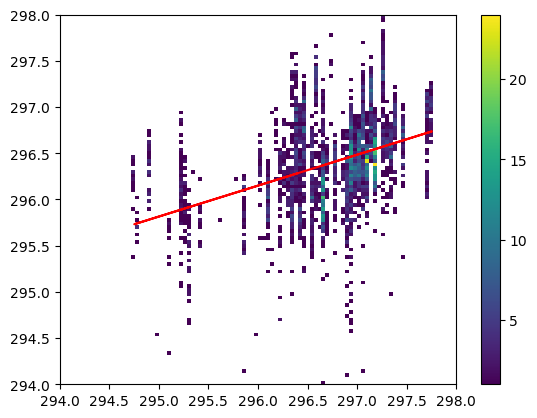

In [ ]:
plt.hist2d(x, y, range=((294,298),(294,298)), bins = 100, cmin=1)
plt.plot(x, fit.slope * x + fit.intercept, c='r')

plt.colorbar()

['0202_61151SOD_windspeed.dat',
 '0202_49423SOD_wspd.eps',
 '0202_44159SOD_temp.eps',
 '0202_51701SOD_windspeed.dat',
 '0202_63537SOD_windspeed.dat',
 '0202_64937SOD.dat',
 '0202_44454SOD_wspd.eps',
 '0202_64937SOD_wspd.eps',
 '0202_64937SOD_temp.eps',
 '0202_43467SOD_wspd.eps',
 '0202_67495SOD_temp.eps',
 '0202_65381SOD_temp.eps',
 '0202_58316SOD_hum.eps',
 '0202_64449SOD_hum.eps',
 '0202_67758SOD_windspeed.dat',
 '0202_43686SOD.dat',
 '0202_70161SOD_wspd.eps',
 '0202_55558SOD_hum.eps',
 '0202_62306SOD_temp.eps',
 '0202_47030SOD_wspd.eps',
 '0202_57999SOD_temp.eps',
 '0202_46346SOD_wspd.eps',
 '0202_69195SOD_hum.eps',
 '0202_64704SOD.dat',
 '0202_59896SOD_temp.eps',
 '0202_64164SOD_wspd.eps',
 '0202_64164SOD_hum.eps',
 '0202_60646SOD_temp.eps',
 '0202_45142SOD_hum.eps',
 '0202_56245SOD_windspeed.dat',
 '0202_63537SOD_wspd.eps',
 '0202_62569SOD_wspd.eps',
 '0202_65880SOD.dat',
 '0202_53227SOD.dat',
 '0202_55558SOD.dat',
 '0202_58316SOD_temp.eps',
 '0202_64937SOD_hum.eps',
 '0202_54430S